In [1]:
from utils import *
%matplotlib inline

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)

In [3]:
train_data, train_results, test_data, test_results = read_data()

In [4]:
from sklearn.ensemble import RandomForestRegressor

def random_forest_regressor(train_data, train_results, test_data, prediction_mode='delta', **est_parameters):
    est = RandomForestRegressor(n_jobs=-1, **est_parameters)
    
    if prediction_mode == 'delta':
        make_results = make_delta
        unmake_results = unmake_delta
    else:
        make_results = lambda train_data, train_results: train_results
        unmake_results = lambda test_data, prediction: prediction
    
    est.fit(to_model_with_features(train_data), to_model(make_results(train_data, train_results))) 
    prediction = unmake_results(test_data, from_model(est.predict(to_model_with_features(test_data))))
        
    return prediction

1/5: 2016-12-11 20:49:29
2/5: 2016-12-11 20:50:08
3/5: 2016-12-11 20:51:16
4/5: 2016-12-11 20:52:53
5/5: 2016-12-11 20:55:02
done! 2016-12-11 20:55:17
Results: [0.41744234792127966, 0.41721917673750453, 0.41542080455807495, 0.41060994178516186, 0.36641111315142694]


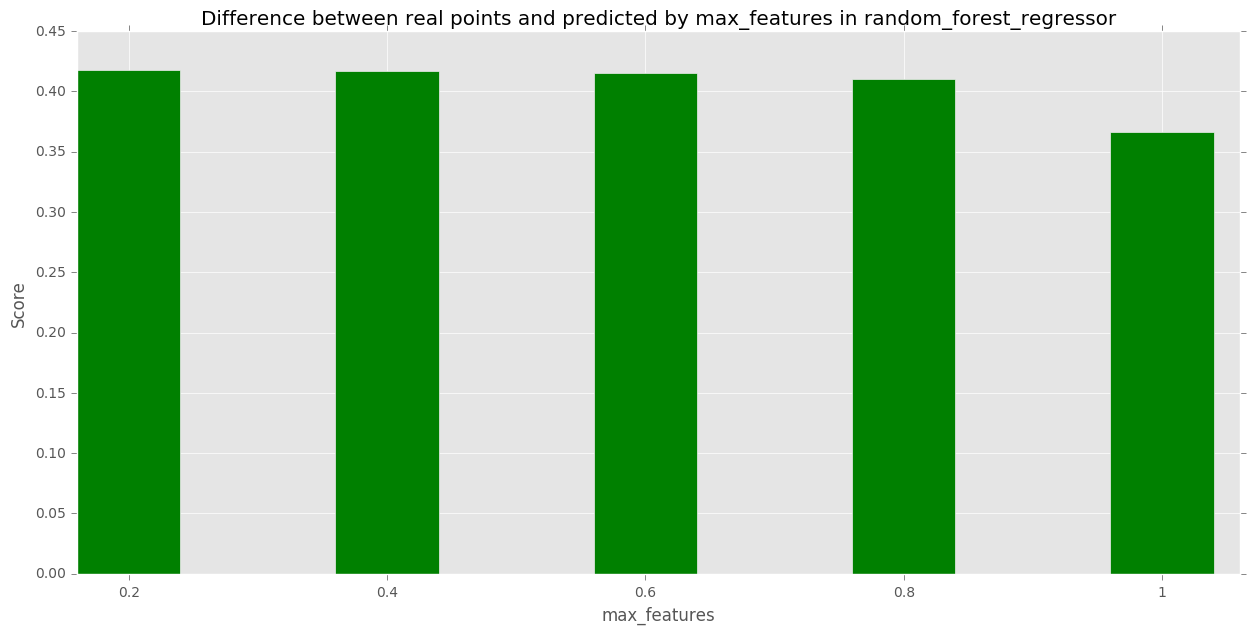

In [5]:
compare_results(function=random_forest_regressor, test_results=test_results, parameter_name="max_features",
                list_of_values=[0.2, 0.4, 0.6, 0.8, 1], train_data=train_data, train_results=train_results,
                test_data=test_data, prediction_mode='delta', n_estimators=50)

1/1: 2016-12-11 20:57:53
done! 2016-12-11 21:00:37
Results: [0.3992713750738851]


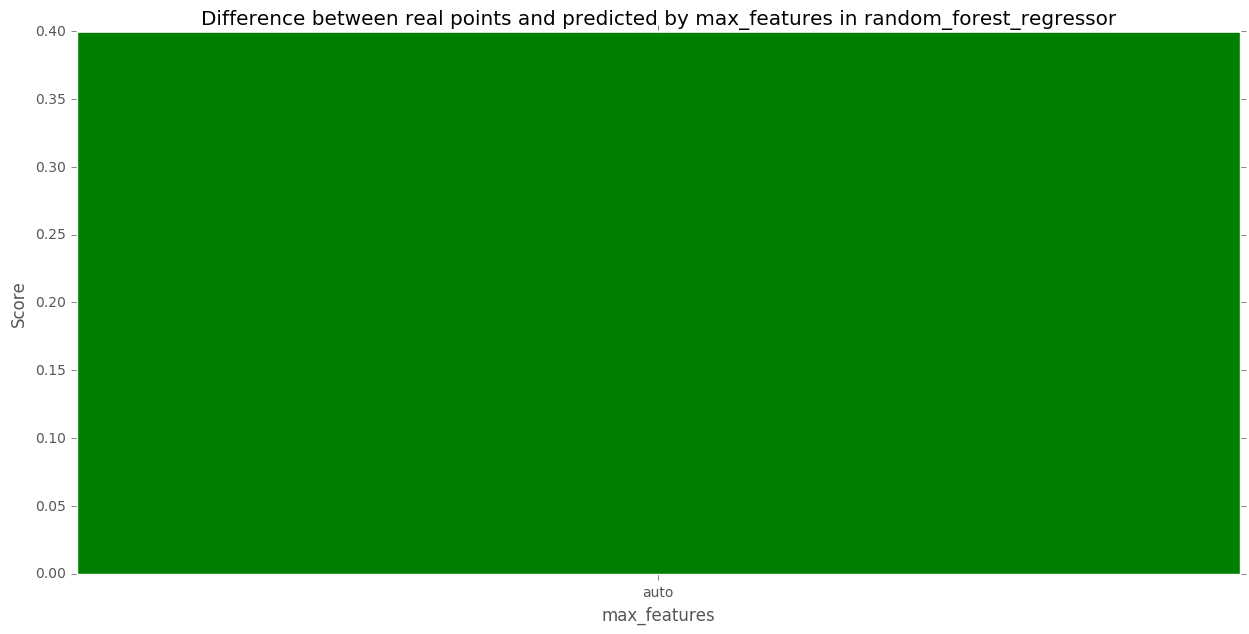

In [6]:
compare_results(function=random_forest_regressor, test_results=test_results, parameter_name="max_features",
                list_of_values=['auto'], train_data=train_data, train_results=train_results,
                test_data=test_data, prediction_mode='delta', n_estimators=50)

In [6]:
est = RandomForestRegressor(n_jobs=-1, n_estimators=50)
    
make_results = make_delta
unmake_results = unmake_delta

est.fit(to_model_with_features(train_data), to_model(make_results(train_data, train_results))) 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [7]:
importances = est.feature_importances_

In [10]:
indices = np.argsort(importances)[::-1]

In [11]:
num_features = to_model_with_features(train_data).shape[1]

In [13]:
print("Feature ranking:")

for f in range(num_features):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 13 (0.556308)
2. feature 17 (0.203280)
3. feature 30 (0.071243)
4. feature 26 (0.042299)
5. feature 16 (0.013158)
6. feature 9 (0.008280)
7. feature 5 (0.007735)
8. feature 4 (0.007477)
9. feature 0 (0.006175)
10. feature 15 (0.005414)
11. feature 10 (0.005190)
12. feature 14 (0.005121)
13. feature 3 (0.004876)
14. feature 12 (0.004807)
15. feature 2 (0.004458)
16. feature 11 (0.004415)
17. feature 1 (0.004389)
18. feature 8 (0.004334)
19. feature 6 (0.004041)
20. feature 7 (0.003846)
21. feature 18 (0.003435)
22. feature 22 (0.003298)
23. feature 20 (0.003277)
24. feature 24 (0.003268)
25. feature 23 (0.003210)
26. feature 19 (0.003133)
27. feature 29 (0.002874)
28. feature 27 (0.002805)
29. feature 21 (0.002686)
30. feature 25 (0.002659)
31. feature 28 (0.002510)


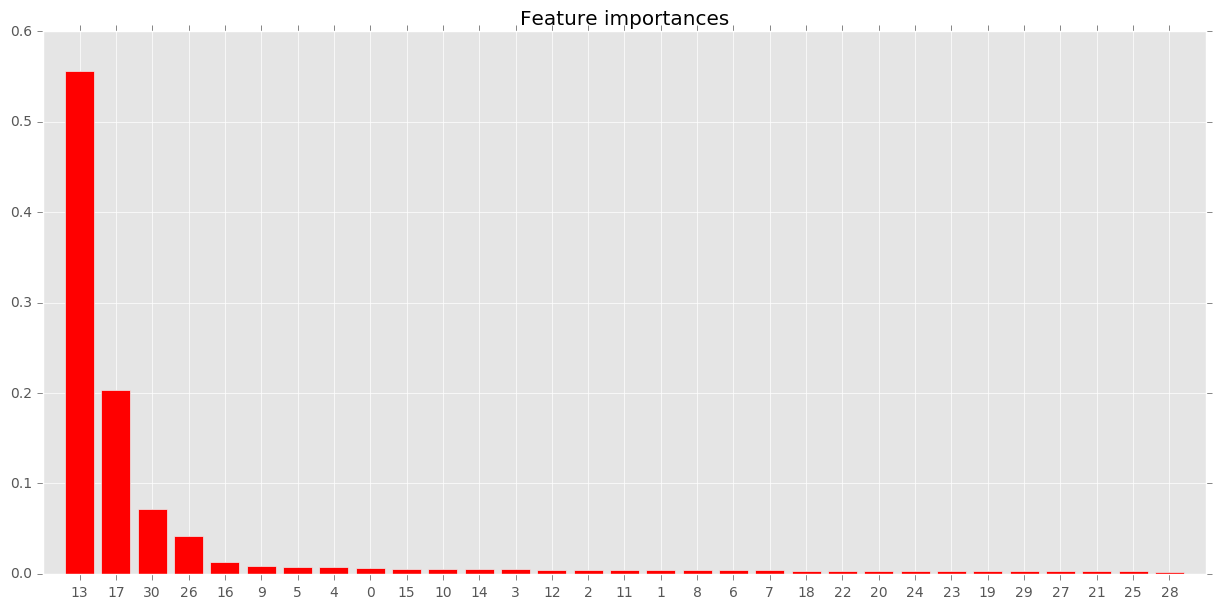

In [14]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices],
       color="r", align="center")
plt.xticks(range(num_features), indices)
plt.xlim([-1, num_features])
plt.show()